# Работу выполнил ***Закиров Ислам*** БИВТ-22-16

**Данный датасет содержит 25 000 записей о росте и весе 18-ти летних людей.**

## Начало

In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from scipy import stats
import seaborn as sns
from itertools import *

In [3]:
df = pd.read_csv('SOCR-HeightWeight.csv')
df.head()

,Index,Height(Inches),Weight(Pounds)
0,1,65.78331,112.9925
1,2,71.51521,136.4873
2,3,69.39874,153.0269
3,4,68.21660,142.3354
4,5,67.78781,144.2971


## Начало анализа

Обратим внимание на ряд числовых показателей:

*   `Index` - Номер исследуемого (id)
*   `Height(Inches)` - Рост в дюймах (1 дюйм = 2,54 см)
*   `Weight(Pounds)` - Вес в фунтах (1 фунт == 450 грамм)


In [5]:
df.describe()

,Index,Height(Inches),Weight(Pounds)
count,25000.000000,25000.000000,25000.000000
mean,12500.500000,67.993114,127.079421
std,7217.022701,1.901679,11.660898
min,1.000000,60.278360,78.014760
25%,6250.750000,66.704397,119.308675
50%,12500.500000,67.995700,127.157750
75%,18750.250000,69.272958,134.892850
max,25000.000000,75.152800,170.924000


## Проверка рейтинга на нормальное распределение

### Визуальный анализ (гистограммы)

Построим гистограммы интеерсующих нас признаков, а также наложим поверх гистограм то, как бы выглядело нормальное распределение с параметрами, рассчитанными на основе выборок.


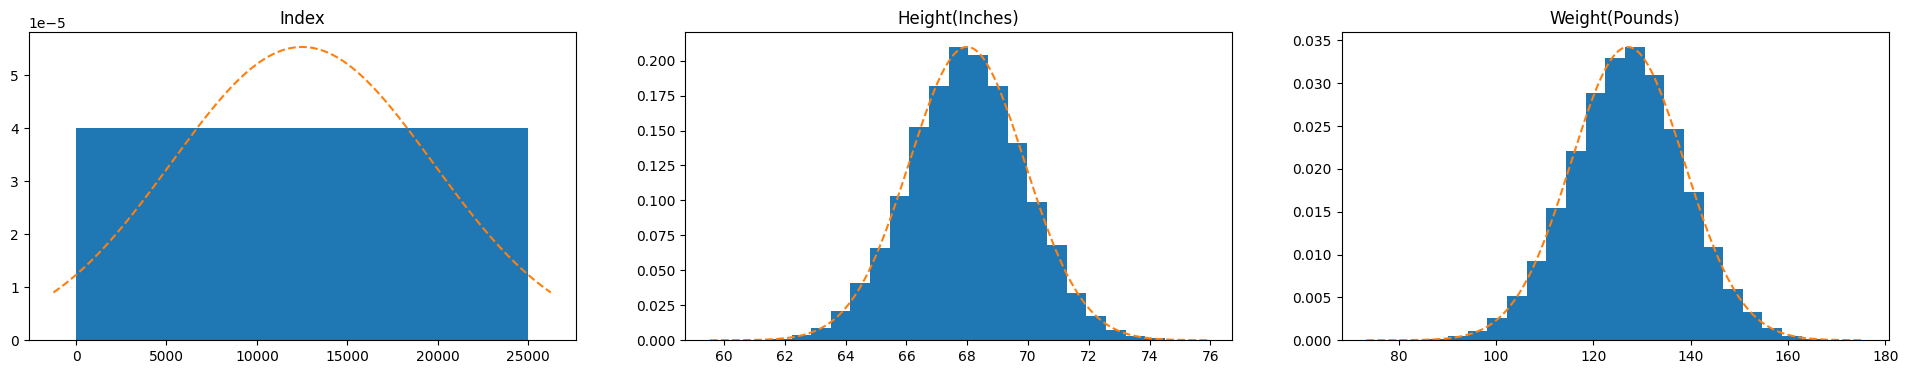

In [9]:
keys = ['Index', 'Height(Inches)', 'Weight(Pounds)']

fig, axes = plt.subplots(ncols=len(keys))
fig.set_size_inches(8 * len(keys), 4)
axes = axes.flatten()

for key, ax in zip(keys, axes):
    ax.hist(df[key], density=True, bins=23)
    
    loc = df[key].mean()
    scale = df[key].std()
    
    x_left, x_right = ax.get_xlim()
    x = np.linspace(x_left, x_right, 10000)
    y = stats.norm.pdf(x, loc=loc, scale=scale)
    
    ax.plot(x, y, linestyle='dashed')
    ax.set_title(key)

По графикам видно, что распределения веса и роста по предметам грубо можно свести к нормальному. Оранжевый пунктир - как бы выглядело нормальное распределение с параметрами, рассчитанными на основе выборок.

### Визуальный анализ (квантили)

Построим Q-Q кривую. Это график, который показывает соответствие между теоретическим значением квантиля на выборке и его реальным значением. 

Чем ближке график к графику $y=x$, тем более нормальным является распределение значений выборки. 

Как мы и говорили ранее `year` не является распределённым нормально. Тогда как `runtime`, `IMDb` распределён относительно нормально.

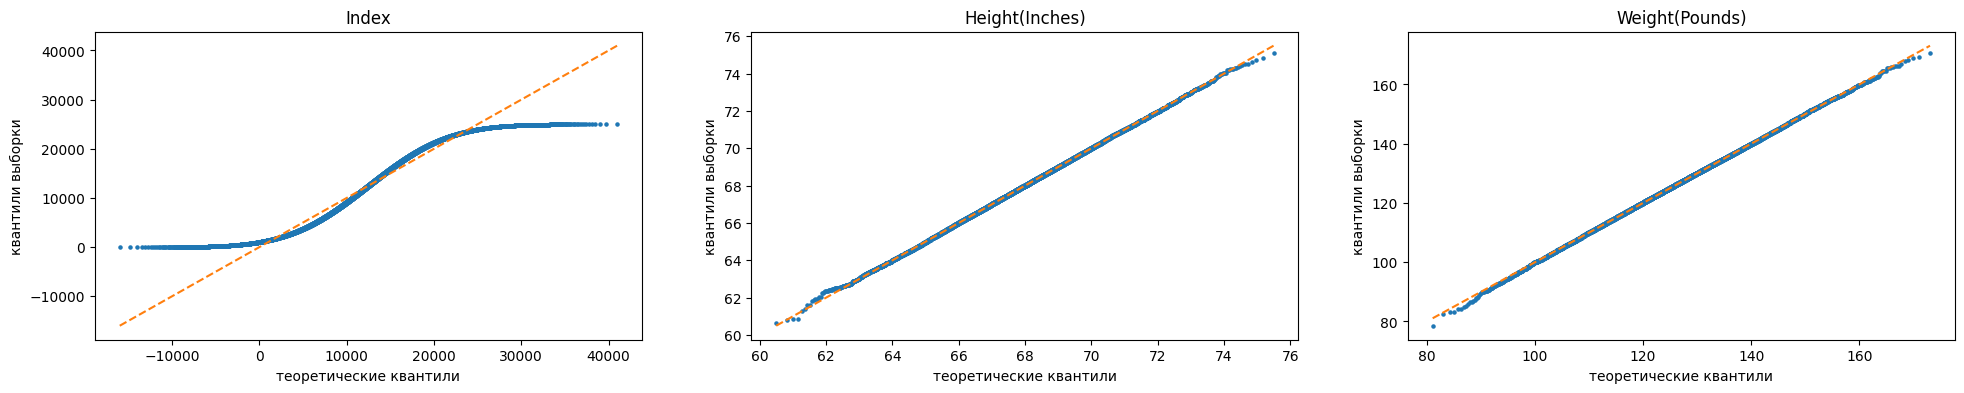

In [10]:
fig, axes = plt.subplots(ncols=len(keys))
fig.set_size_inches(8 * len(keys), 4)
axes = axes.flatten()

for key, ax in zip(keys, axes):
    samples = df[key]
    
    loc = samples.mean()
    scale = samples.std()
    
    interval = np.linspace(0, 1, samples.shape[0])[1:-1]
    x = stats.norm.ppf(interval, loc=loc, scale=scale)
    y = np.quantile(samples, interval)
    
    ax.scatter(x, y, s=5)
    ax.plot(x, x, color='C1', linestyle='dashed')
    
    ax.set_title(key)
    ax.set_xlabel('теоретические квантили')
    ax.set_ylabel('квантили выборки')

Q-Q кривая. График, который показывает соответствие между теоретическим значением квантиля на выборке и его реальным значением. Видно, что распределения относительно нормальны.

### Стастические показатели для выборок

Оценим нормальность выборок также  на основании известных характеристик нормального распределения. В частности:
* Вероятность попасть в интервал от $\mu - \sigma$ до $\mu + \sigma$ равна $0.68$,
* В интервал от $\mu - 2\sigma$ до $\mu + 2\sigma$ — $0.95$,
* В интервал от $\mu - 3\sigma$ до $\mu + 3\sigma$ — $0.997$.

Если рассчётные цифры оказываются близки к теоретическим, то распределения можно признать нормальными. 
Тот факт, что распределения данных значений явлются нормальными или близкими к ним позволяет использовать другие методы для анализа взаимосвязей в данных.

In [11]:
for key in keys:
    print(key)
    
    samples = df[key]
    
    loc = samples.mean()
    scale = samples.std()

    for i in range(1, 4):
        true_value = stats.norm.cdf(i) - stats.norm.cdf(-i)
        sample_value = ((samples >= loc - i * scale) & (samples <= loc + i * scale)).sum() / samples.shape[0]
        
        print(f'{i} sigma(s)')
        print(f'\ttheoretical:\t{true_value}')
        print(f'\tsample:\t\t{sample_value}')
        
    print()

Index
1 sigma(s)
	theoretical:	0.6826894921370859
	sample:		0.57736
2 sigma(s)
	theoretical:	0.9544997361036416
	sample:		1.0
3 sigma(s)
	theoretical:	0.9973002039367398
	sample:		1.0

Height(Inches)
1 sigma(s)
	theoretical:	0.6826894921370859
	sample:		0.68356
2 sigma(s)
	theoretical:	0.9544997361036416
	sample:		0.9546
3 sigma(s)
	theoretical:	0.9973002039367398
	sample:		0.99796

Weight(Pounds)
1 sigma(s)
	theoretical:	0.6826894921370859
	sample:		0.6852
2 sigma(s)
	theoretical:	0.9544997361036416
	sample:		0.95284
3 sigma(s)
	theoretical:	0.9973002039367398
	sample:		0.99724



## Корелляционная сетка - тепловая карта

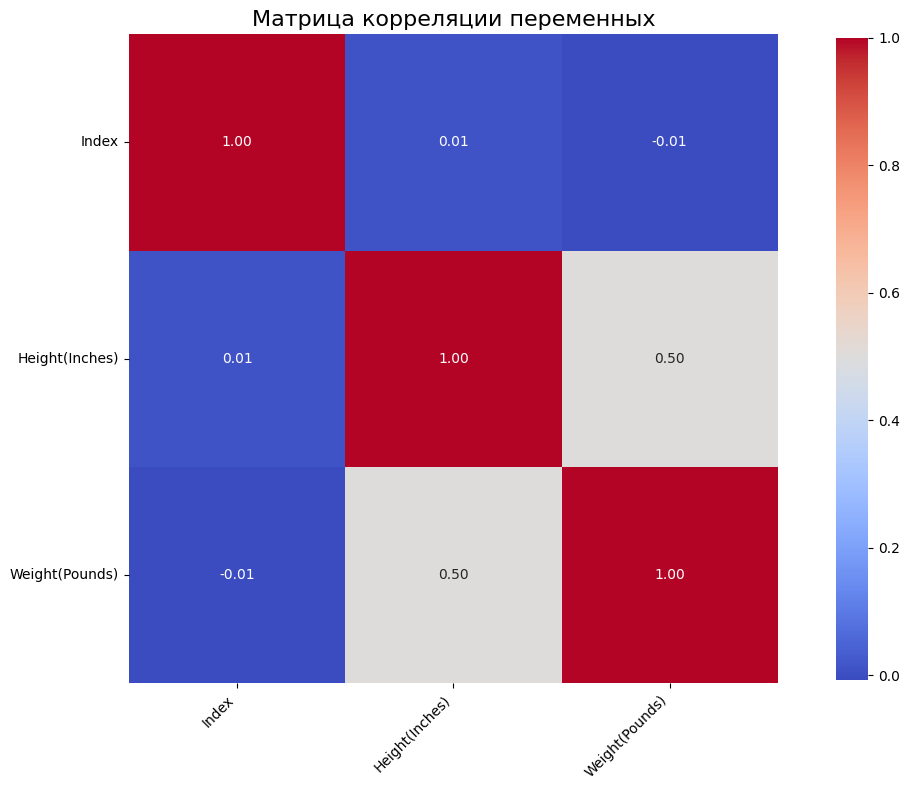

In [12]:
numeric_columns = df.select_dtypes(include=['number'])
correlation_matrix = numeric_columns.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .99})

plt.title('Матрица корреляции переменных', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()

## Анализ данных роста с помощью boxplot

<Axes: ylabel='Height(Inches)'>

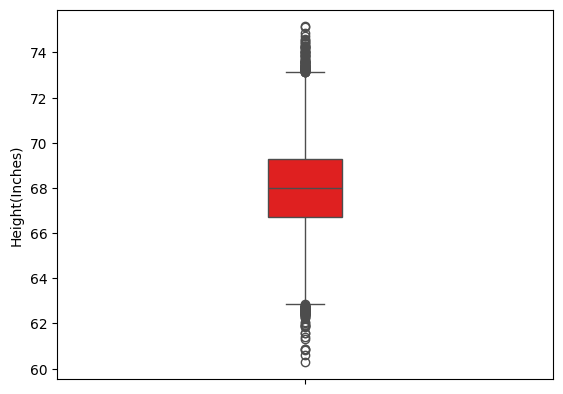

In [15]:
sns.boxplot(df['Height(Inches)'], orient='v', width=0.15, color = 'red')

## Анализ данных веса с помощью boxplot

<Axes: ylabel='Weight(Pounds)'>

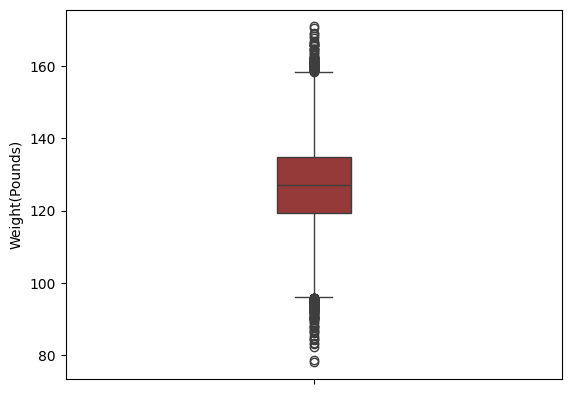

In [14]:
sns.boxplot(df['Weight(Pounds)'], orient='v', width=0.15, color = 'brown')

In [17]:
df=df.drop(columns='Index')
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3- Q1

lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

print(f'Lower bound:\n{lower}\n\nUpper bound:\n{upper}')

Lower bound:
Height(Inches)    62.851557
Weight(Pounds)    95.932412
dtype: float64

Upper bound:
Height(Inches)     73.125798
Weight(Pounds)    158.269113
dtype: float64


In [23]:
df[(df['Height(Inches)'] > 73.69) | (df['Height(Inches)'] < 62.85)]

,Height(Inches),Weight(Pounds)
138,73.90107,151.3913
174,73.83364,139.2983
412,62.01666,109.0848
1133,62.75039,114.4900
1162,74.24899,150.2167
...,...,...
23039,73.95494,154.3987
23041,62.37478,129.2900
24244,62.26498,104.1348
24475,62.68591,118.6002


In [24]:
df[(df['Weight(Pounds)'] > 158.27) | (df['Weight(Pounds)'] < 95.9)]

,Height(Inches),Weight(Pounds)
156,70.98112,158.95620
249,65.93895,84.35980
293,69.13438,92.74955
367,72.32489,168.22900
446,69.16807,162.41090
...,...,...
24187,69.21155,161.85040
24610,66.56804,82.38298
24750,70.82192,159.63440
24835,65.17339,94.40946


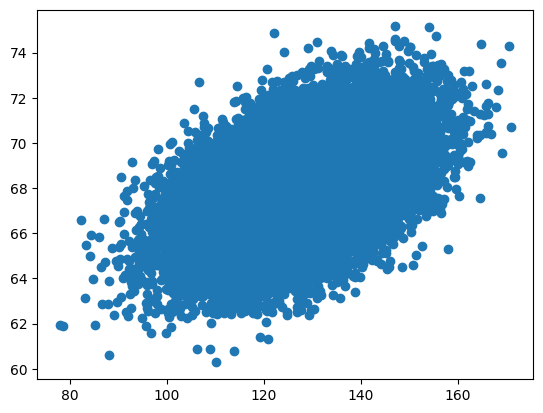

In [19]:
plt.scatter(df["Weight(Pounds)"],df["Height(Inches)"])

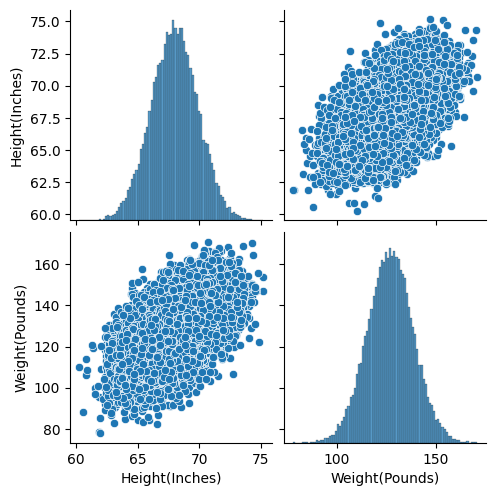

In [20]:
sns.pairplot(df)

## Прослеживаются ли зависимости между весом и ростом у людей?

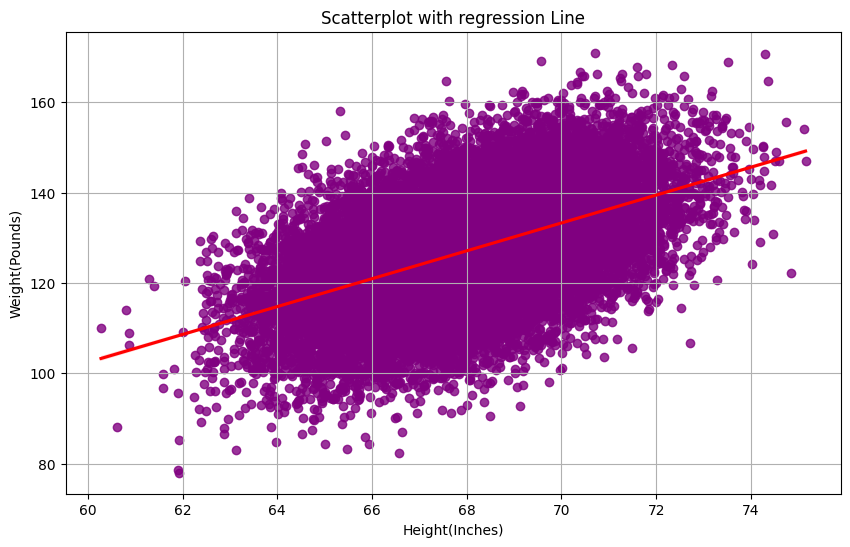

In [33]:
data = {
    'x': df['Height(Inches)'],
    'y': df['Weight(Pounds)']
}
df1 = pd.DataFrame(data)

plt.figure(figsize=(10, 6))
sns.regplot(x='x', y='y', data=df1, scatter_kws={'color': 'purple'}, line_kws={'color': 'red'})
plt.title('Scatterplot with regression Line')
plt.xlabel('Height(Inches)')
plt.ylabel('Weight(Pounds)')
plt.grid(True)
plt.show()

Можно сделать вывод, что связь между весом и ростом ***имеется***!!!

In [18]:
def sum_of_squares(samples: np.ndarray) -> float:
    return ((samples - samples.mean()) ** 2).sum()

ones = np.ones((25000, 1))
x_pot = np.hstack((ones, df['Weight(Pounds)'].values.reshape(25000, 1)))

XTX = x_pot.T.dot(x_pot)
XTX_inv = np.linalg.inv(XTX)

b = XTX_inv.dot(x_pot.T).dot(df['Height(Inches)'])
z = x_pot.dot(b)
e = df['Height(Inches)'].values - z.flatten() 

R = 1 - sum_of_squares(e) / sum_of_squares(df['Height(Inches)'].values)
print(R)


0.2528666917428807
